In [1]:
get_ipython().run_cell_magic('capture', '', "%logstop\n%logstart -t -r -q ipython_command_log.py global\n\n#- IRONHACKS RESEARCH TRACKING CODE\n#----------------------------------\n# The following code is used to help our research team understand how you \n# our notebook environment. We do not collect any personal information with\n# the following code, it is used to measure when and how often you work on\n# your submission files.\n\nimport os\nfrom datetime import datetime\nimport IPython.core.history as history\n\nha = history.HistoryAccessor()\nha_tail = ha.get_tail(1)\nha_cmd = next(ha_tail)\nsession_id = str(ha_cmd[0])\ncommand_id = str(ha_cmd[1])\ntimestamp = datetime.utcnow().isoformat()\nhistory_line = ','.join([session_id, command_id, timestamp]) + '\\n'\nlogfile = open(os.environ['HOME']+'/ipython_session_log.csv', 'a')\nlogfile.write(history_line)\nlogfile.close()\n")

In [2]:
get_ipython().run_cell_magic('capture', '', "\n#- INSTALL ADDITIONAL LIBRARIES IF REQUIRED\n#------------------------------------------\n# This is normally not required. The hub environment comes preinstaled with \n# many packages that you can already use without setup. In case there is some\n# other library you would like to use that isn't on the list you run this command\n# once to install them.  If it is already installed this command has no effect.\n\n!python3 -m pip install pandas\n!pip install db-dtypes\n")

- IMPORT THE LIBRARIES YOU WILL USE
------------------------------------------
You only need to import packages one time per notebook session. To keep your
notebook clean and organized you can handle all imports at the top of your file.
The following are included for example purposed, feel free to modify or delete 
anything in this section.

In [3]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from statsmodels.formula.api import ols
from pandas import Series, DataFrame

CONFIGURE THE BIGQUERY SETTINGS

In [4]:
BIGQUERY_PROJECT = 'ironhacks-data'
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [5]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.unemployment_data`
"""

In [6]:
query_job = bigquery_client.query(query)
unemployment_data = query_job.to_dataframe()
unemployment_data.head()

,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white
0,f013068de98db1470bd986137a0c6d23,20220416,16,18003,900,"Census Tract 9, Allen County, Indiana",22,0,<NA>,14,...,<NA>,<NA>,0,0,0,11,0,0,<NA>,<NA>
1,21957d5517323845818d87623589e1ba,20220319,12,18089,10400,"Census Tract 104, Lake County, Indiana",111,0,<NA>,108,...,76,35,0,0,0,<NA>,<NA>,0,0,0
2,6a5609f385912113b6f1014b958ed748,20220326,13,18089,11500,"Census Tract 115, Lake County, Indiana",39,0,<NA>,<NA>,...,<NA>,<NA>,0,0,0,39,0,0,0,0
3,46b2882ec4c373527ec33f7bd4f1388d,20220716,29,18089,20700,"Census Tract 207, Lake County, Indiana",14,0,<NA>,<NA>,...,<NA>,<NA>,0,0,<NA>,10,0,0,<NA>,<NA>
4,37495d17e82f7df326bfc2c4c090f7b7,20220409,15,18089,21900,"Census Tract 219, Lake County, Indiana",155,0,<NA>,69,...,90,65,0,0,0,135,<NA>,<NA>,<NA>,<NA>


In [7]:
query2 = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.wage_data`
"""

In [8]:
query_job2 = bigquery_client.query(query2)
wage_data = query_job2.to_dataframe()
wage_data.head()

,uu_id,countyfips,tract,tract_name,average_wage
0,585f8731c2255d6b3f817a31180848b9,18177,200,"Census Tract 2, Wayne County, Indiana",6612.000000
1,8c9d2aa90948679972a9382aadcc6001,18177,900,"Census Tract 9, Wayne County, Indiana",9883.250000
2,0f3d45341a5b113b813ffb7be7f58bab,18183,50300,"Census Tract 503, Whitley County, Indiana",13992.250000
3,fb55464f8e34af6d750d06968bf719b8,18183,50400,"Census Tract 504, Whitley County, Indiana",13613.500000
4,983badfd7b568728e39a2344a9006078,18001,30200,"Census Tract 302, Adams County, Indiana",11816.666667


In [9]:
wage_data[wage_data.isnull().any(axis=1)]

,uu_id,countyfips,tract,tract_name,average_wage


In [10]:
wage_data2 = wage_data.fillna({'average_wage': wage_data.average_wage.mean()})
wage_data2.head()

,uu_id,countyfips,tract,tract_name,average_wage
0,585f8731c2255d6b3f817a31180848b9,18177,200,"Census Tract 2, Wayne County, Indiana",6612.000000
1,8c9d2aa90948679972a9382aadcc6001,18177,900,"Census Tract 9, Wayne County, Indiana",9883.250000
2,0f3d45341a5b113b813ffb7be7f58bab,18183,50300,"Census Tract 503, Whitley County, Indiana",13992.250000
3,fb55464f8e34af6d750d06968bf719b8,18183,50400,"Census Tract 504, Whitley County, Indiana",13613.500000
4,983badfd7b568728e39a2344a9006078,18001,30200,"Census Tract 302, Adams County, Indiana",11816.666667


In [11]:
query3 = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.prediction_list`
"""

In [12]:
query_job3 = bigquery_client.query(query3)
prediction_list = query_job3.to_dataframe()
prediction_list.head()

,uu_id,week_number
0,5bf51fc2e162d6faf9e3cf79e4198378,44
1,420b44cc7e3f55d738df565421e59941,44
2,e39c66ecceec76ee8f9f811fa4a2d246,44
3,a90462cd11ae4e43144239bf7c4828a4,44
4,8b20a6749088c7ff1237983076ebfeaa,44


In [13]:
unemploy_wage_data = pd.merge(unemployment_data, wage_data, on=['uu_id'], how='inner')
unemploy_wage_data = unemploy_wage_data.drop(['timeperiod', 'countyfips_y', 'tract_y', 'tract_name_y'], axis=1)
unemploy_wage_data = unemploy_wage_data.fillna(0)
unemploy_wage_data.head()

,uu_id,week_number,countyfips_x,tract_x,tract_name_x,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,...,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,average_wage
0,f013068de98db1470bd986137a0c6d23,16,18003,900,"Census Tract 9, Allen County, Indiana",22,0,0,14,0,...,0,0,0,0,11,0,0,0,0,8347.125
1,f013068de98db1470bd986137a0c6d23,7,18003,900,"Census Tract 9, Allen County, Indiana",10,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8347.125
2,f013068de98db1470bd986137a0c6d23,35,18003,900,"Census Tract 9, Allen County, Indiana",11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8347.125
3,f013068de98db1470bd986137a0c6d23,11,18003,900,"Census Tract 9, Allen County, Indiana",11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8347.125
4,f013068de98db1470bd986137a0c6d23,6,18003,900,"Census Tract 9, Allen County, Indiana",11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8347.125


In [14]:
unemploy_wage_data.describe()

,week_number,countyfips_x,tract_x,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,average_wage
count,16833.0,16833.0,16833.0,16833.0,16833.0,16833.0,16833.0,16833.0,16833.0,16833.0,16833.0,16833.0,16833.0,16833.0,16833.0,16833.0,16833.0,16833.0,16833.0,16833.000000
mean,21.329531,18088.919682,211605.900315,22.952712,0.041644,0.455771,6.927642,3.263471,0.094339,4.319076,4.597992,0.005228,0.009921,0.012475,4.544526,0.124161,0.0,0.241965,6.57417,11695.354680
std,11.618554,41.019467,288715.02492,14.583655,0.953462,3.220428,11.931776,8.21234,1.499568,9.782507,10.175552,0.441002,0.469947,0.535979,11.640663,1.947116,0.0,2.336547,11.040787,4123.648325
min,1.0,18001.0,100.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3992.500000
25%,11.0,18063.0,10100.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8807.166667
50%,22.0,18095.0,42801.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11045.000000
75%,32.0,18103.0,342600.0,27.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,13908.333333
max,37.0,18183.0,976400.0,170.0,41.0,78.0,137.0,154.0,60.0,126.0,139.0,49.0,36.0,41.0,163.0,110.0,0.0,74.0,155.0,41267.000000


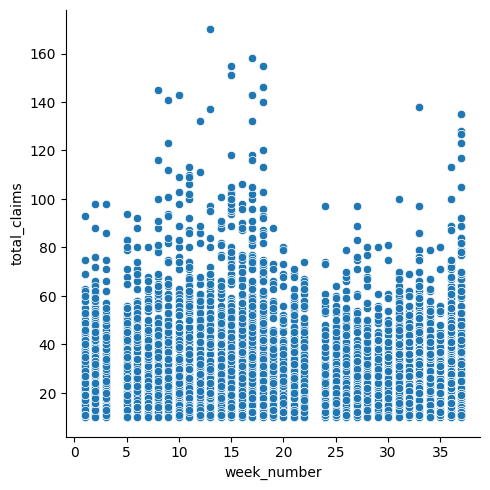

In [15]:
sns.relplot(data=unemploy_wage_data, x='week_number', y='total_claims')

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_15249/3614273883.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(unemploy_wage_data.total_claims, bins=10)


<AxesSubplot: xlabel='total_claims', ylabel='Density'>

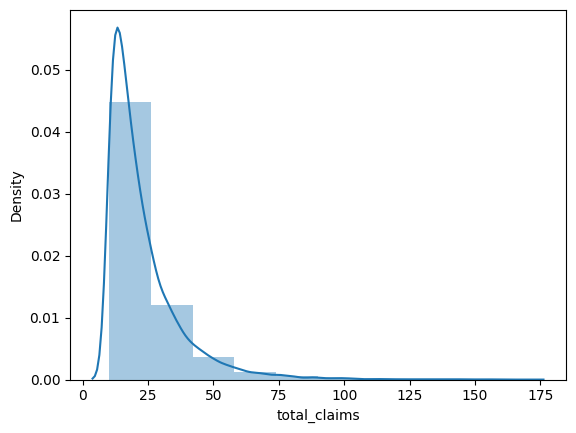

In [16]:
sns.distplot(unemploy_wage_data.total_claims, bins=10)

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_15249/1957946244.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = unemploy_wage_data.corr()


<AxesSubplot: >

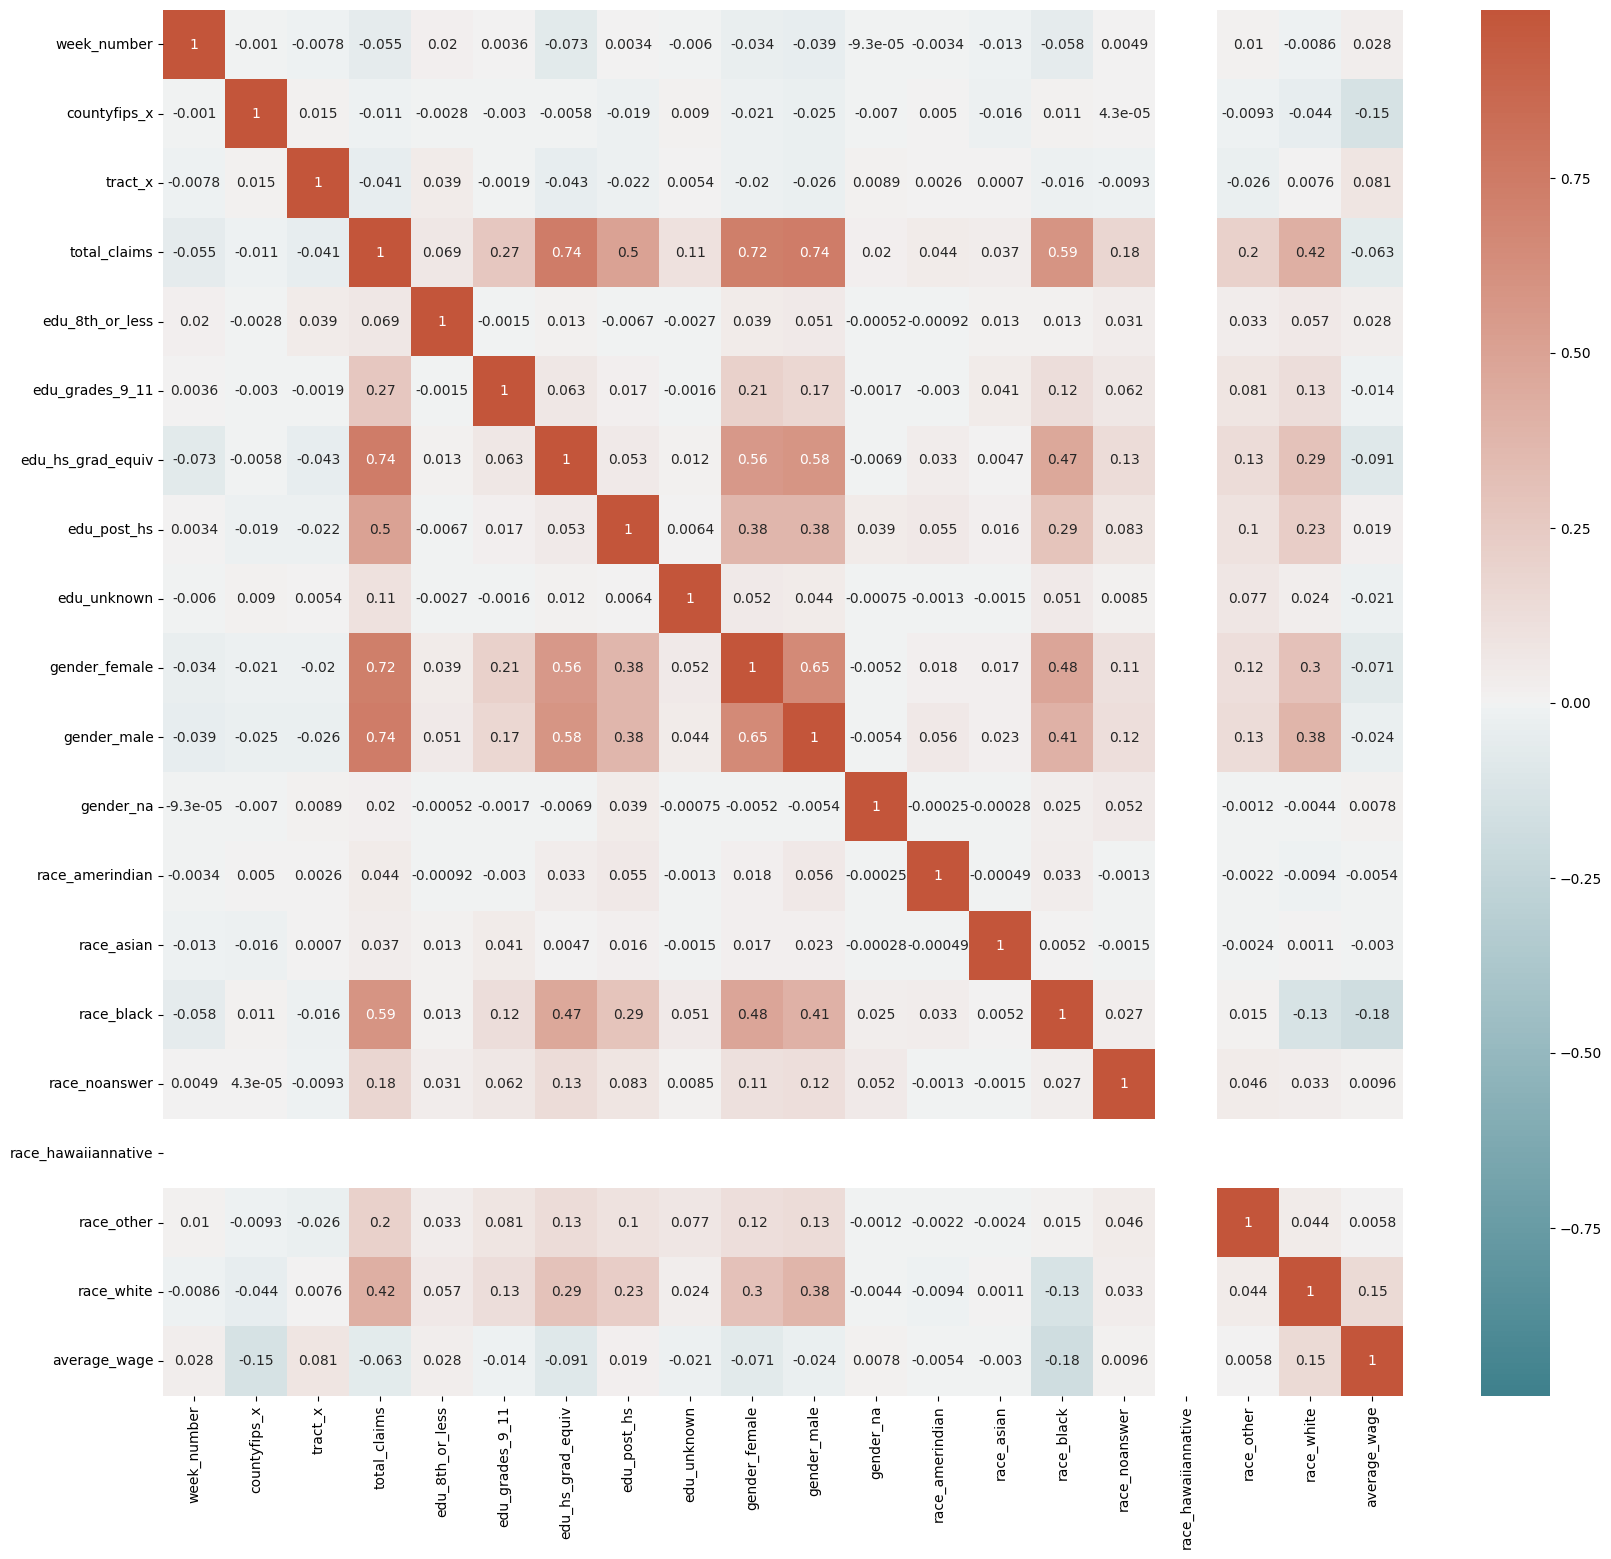

In [17]:
plt.figure(figsize=(20,18))
cor = unemploy_wage_data.corr()
cmap = sns.diverging_palette(210, 20, as_cmap=True)
sns.heatmap(cor, cmap=cmap, vmax=.99, vmin=-.99, annot=True)

In [18]:
X = unemploy_wage_data[['week_number', 'countyfips_x', 'tract_x', 'edu_8th_or_less', 'edu_grades_9_11', \
                        'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown', 'gender_female', 'gender_male', \
                        'gender_na', 'race_amerindian', 'race_asian', 'race_black', 'race_noanswer', \
                        'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']]
y = unemploy_wage_data['total_claims']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [20]:
print(f'intercept: {reg.intercept_}')
coef = DataFrame(reg.coef_, X.columns, columns=['coefficients'])
print(coef)

NameError: name 'reg' is not defined

In [21]:
reg = LinearRegression()  
reg.fit(X_train, y_train)
print(reg)

LinearRegression()


In [22]:
print(f'intercept: {reg.intercept_}')
coef = DataFrame(reg.coef_, X.columns, columns=['coefficients'])
print(coef)

intercept: -41.43270574771155
                     coefficients
week_number         -4.017355e-03
countyfips_x         3.032468e-03
tract_x             -4.329671e-07
edu_8th_or_less      6.494605e-01
edu_grades_9_11      6.563795e-01
edu_hs_grad_equiv    5.308050e-01
edu_post_hs          5.034803e-01
edu_unknown          6.998567e-01
gender_female        1.381438e-01
gender_male          1.938021e-01
gender_na            2.355927e-01
race_amerindian      5.257421e-02
race_asian           3.305595e-01
race_black           2.504164e-01
race_noanswer        3.173699e-01
race_hawaiiannative  1.110223e-16
race_other           3.611096e-01
race_white           1.946824e-01
average_wage        -5.541546e-06


In [23]:
y_pred = reg.predict(X_test)
df = DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
3634,27,33.331490
752,46,31.731512
6122,21,24.823834
12636,21,21.626032
7772,41,33.011088
...,...,...
6196,39,40.238290
8309,17,22.091985
8451,18,16.718705
13667,42,40.580703


In [24]:
print('R squared: {:.2f}'.format(reg.score(X, y)*100))
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R squared: 88.23
MAE: 3.436078991198356
MSE: 29.4735499906019
RMSE: 5.428954778831916


In [25]:
df['Predicted'].mean()

23.02213666707166

In [26]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.unemployment_data`
"""

In [27]:
query_job = bigquery_client.query(query)
unemployment_data = query_job.to_dataframe()
unemployment_data

,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white
0,f013068de98db1470bd986137a0c6d23,20220416,16,18003,900,"Census Tract 9, Allen County, Indiana",22,0,<NA>,14,...,<NA>,<NA>,0,0,0,11,0,0,<NA>,<NA>
1,21957d5517323845818d87623589e1ba,20220319,12,18089,10400,"Census Tract 104, Lake County, Indiana",111,0,<NA>,108,...,76,35,0,0,0,<NA>,<NA>,0,0,0
2,6a5609f385912113b6f1014b958ed748,20220326,13,18089,11500,"Census Tract 115, Lake County, Indiana",39,0,<NA>,<NA>,...,<NA>,<NA>,0,0,0,39,0,0,0,0
3,46b2882ec4c373527ec33f7bd4f1388d,20220716,29,18089,20700,"Census Tract 207, Lake County, Indiana",14,0,<NA>,<NA>,...,<NA>,<NA>,0,0,<NA>,10,0,0,<NA>,<NA>
4,37495d17e82f7df326bfc2c4c090f7b7,20220409,15,18089,21900,"Census Tract 219, Lake County, Indiana",155,0,<NA>,69,...,90,65,0,0,0,135,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16828,f35320206f3dd1ffc411e4ac127caf92,20220618,25,18163,3804,"Census Tract 38.04, Vanderburgh County, Indiana",21,0,<NA>,<NA>,...,<NA>,<NA>,0,0,0,<NA>,<NA>,0,<NA>,14
16829,f35320206f3dd1ffc411e4ac127caf92,20220827,35,18163,3804,"Census Tract 38.04, Vanderburgh County, Indiana",22,0,<NA>,13,...,<NA>,<NA>,0,0,0,<NA>,<NA>,0,<NA>,<NA>
16830,f35320206f3dd1ffc411e4ac127caf92,20220827,35,18163,3804,"Census Tract 38.04, Vanderburgh County, Indiana",22,0,<NA>,13,...,<NA>,<NA>,0,0,0,<NA>,<NA>,0,<NA>,<NA>
16831,bbcb018f0e5e49e13636f6e78ce9f60f,20220326,13,18163,10203,"Census Tract 102.03, Vanderburgh County, Indiana",53,0,<NA>,48,...,<NA>,<NA>,0,0,0,<NA>,<NA>,0,0,<NA>


In [28]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.unemployment_data`
"""

In [29]:
query_job = bigquery_client.query(query)
unemployment_data = query_job.to_dataframe()
unemployment_data()

TypeError: 'DataFrame' object is not callable

In [30]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.unemployment_data`
"""

In [31]:
query_job = bigquery_client.query(query)
unemployment_data = query_job.to_dataframe()
unemployment_data.head()

,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white
0,f013068de98db1470bd986137a0c6d23,20220416,16,18003,900,"Census Tract 9, Allen County, Indiana",22,0,<NA>,14,...,<NA>,<NA>,0,0,0,11,0,0,<NA>,<NA>
1,21957d5517323845818d87623589e1ba,20220319,12,18089,10400,"Census Tract 104, Lake County, Indiana",111,0,<NA>,108,...,76,35,0,0,0,<NA>,<NA>,0,0,0
2,6a5609f385912113b6f1014b958ed748,20220326,13,18089,11500,"Census Tract 115, Lake County, Indiana",39,0,<NA>,<NA>,...,<NA>,<NA>,0,0,0,39,0,0,0,0
3,46b2882ec4c373527ec33f7bd4f1388d,20220716,29,18089,20700,"Census Tract 207, Lake County, Indiana",14,0,<NA>,<NA>,...,<NA>,<NA>,0,0,<NA>,10,0,0,<NA>,<NA>
4,37495d17e82f7df326bfc2c4c090f7b7,20220409,15,18089,21900,"Census Tract 219, Lake County, Indiana",155,0,<NA>,69,...,90,65,0,0,0,135,<NA>,<NA>,<NA>,<NA>


/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_15249/2854089388.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = unemploy_wage_data.corr()


<AxesSubplot: >

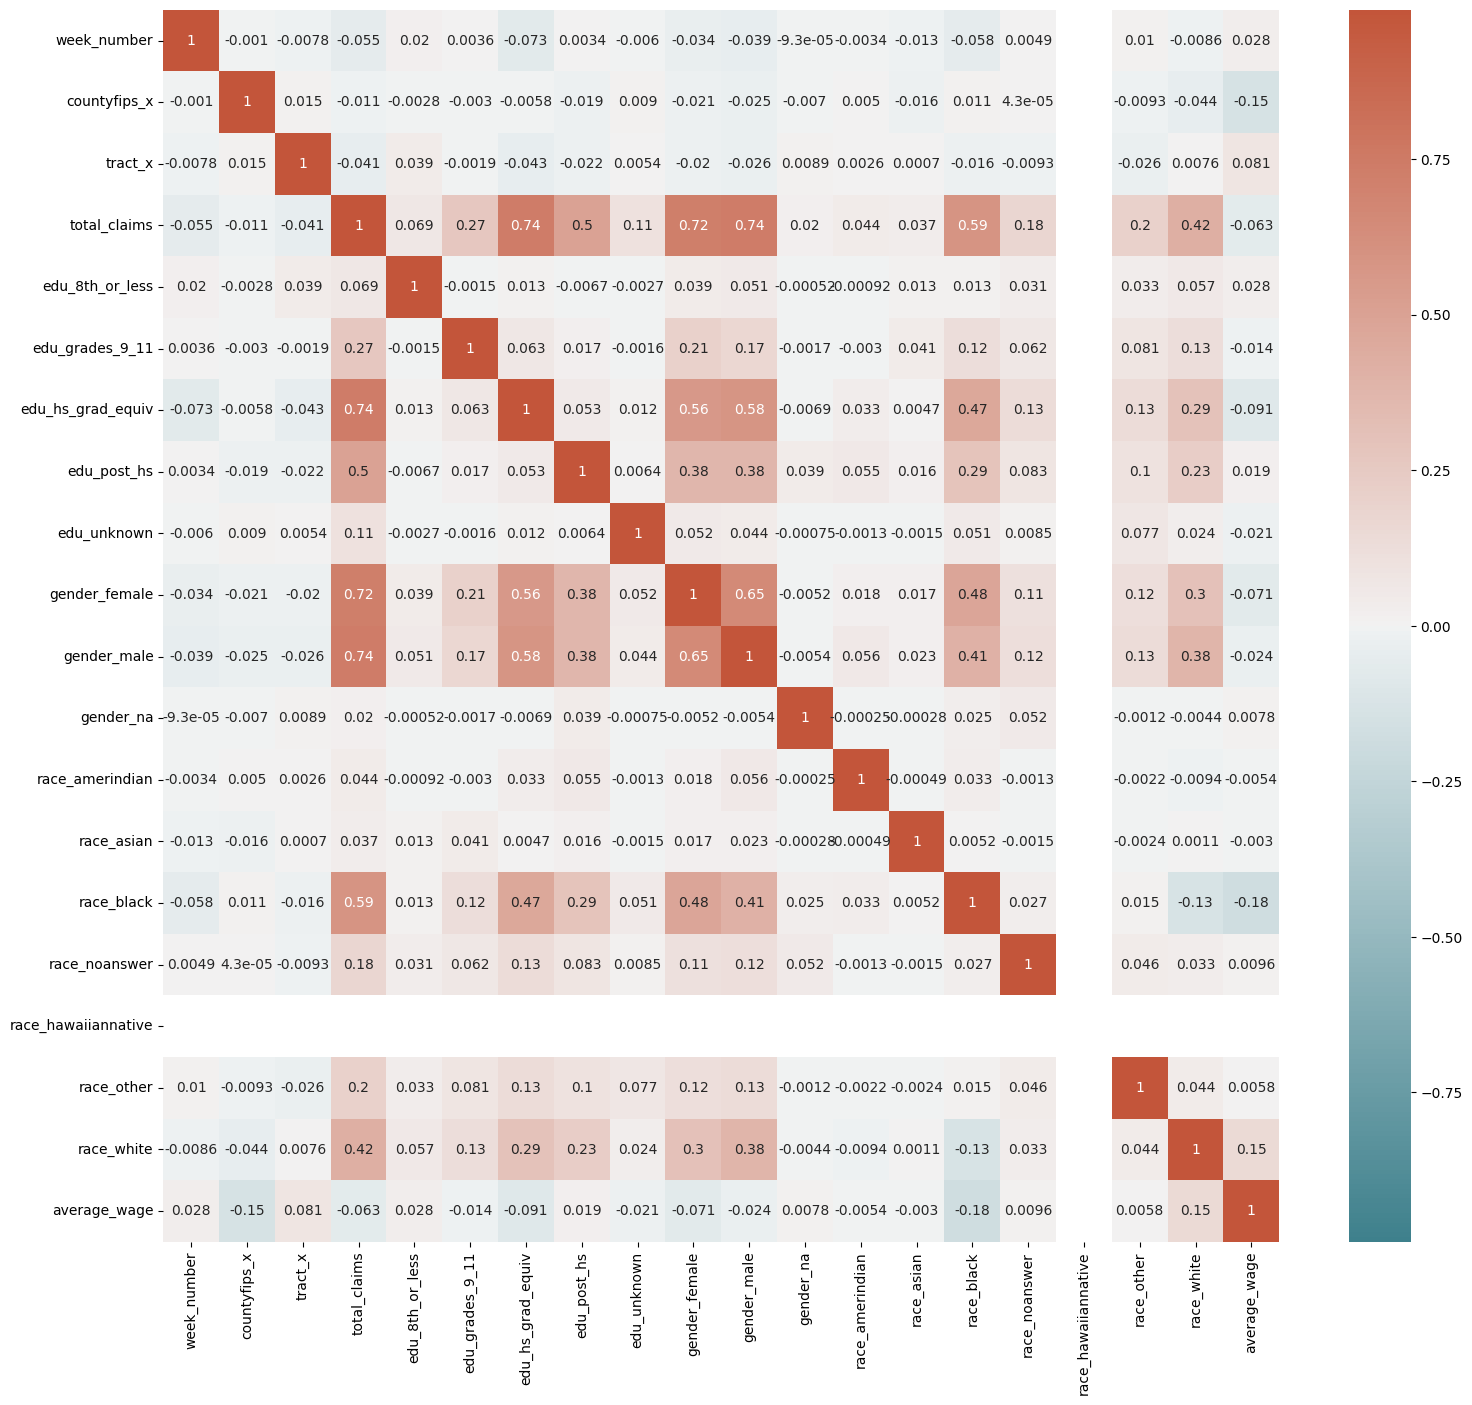

In [32]:
plt.figure(figsize=(18,16))
cor = unemploy_wage_data.corr()
cmap = sns.diverging_palette(210, 20, as_cmap=True)
sns.heatmap(cor, cmap=cmap, vmax=.99, vmin=-.99, annot=True)

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_15249/3945066265.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = unemploy_wage_data.corr()


<AxesSubplot: >

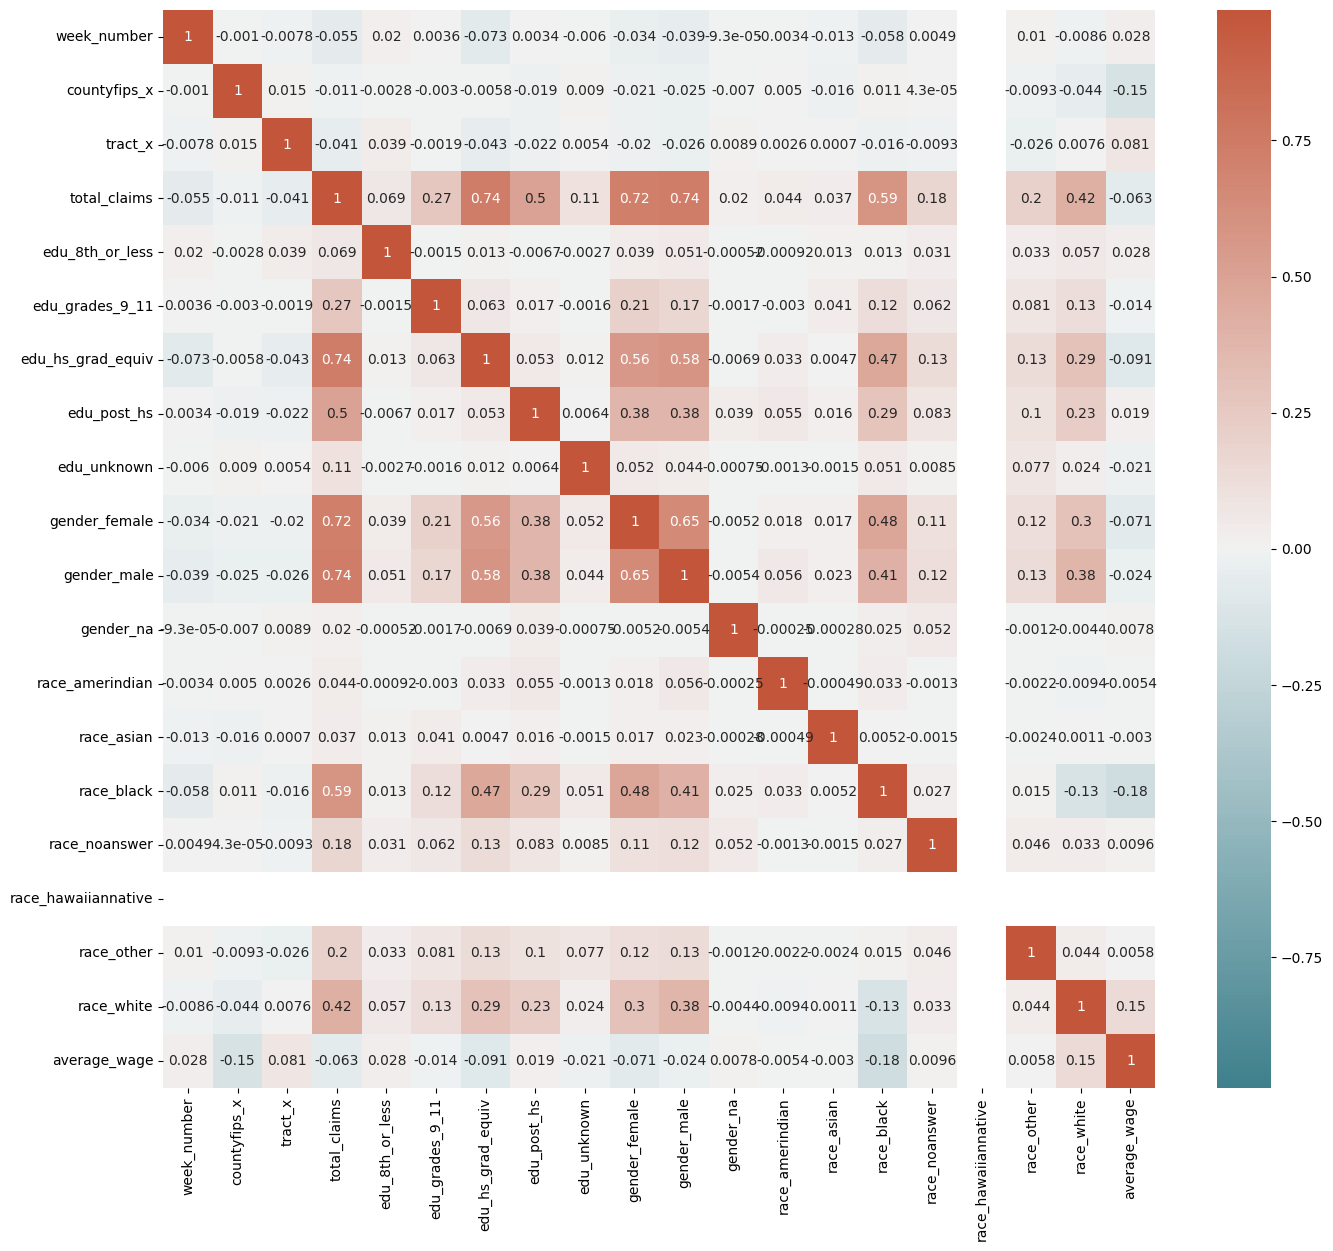

In [33]:
plt.figure(figsize=(16,14))
cor = unemploy_wage_data.corr()
cmap = sns.diverging_palette(210, 20, as_cmap=True)
sns.heatmap(cor, cmap=cmap, vmax=.99, vmin=-.99, annot=True)

In [34]:
predicted_unemploy = pd.merge(unemploy_wage_data,df)

MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

In [35]:
query3 = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.prediction_list`
"""

In [36]:
query_job3 = bigquery_client.query(query3)
prediction_list = query_job3.to_dataframe()
prediction_list

,uu_id,week_number
0,5bf51fc2e162d6faf9e3cf79e4198378,44
1,420b44cc7e3f55d738df565421e59941,44
2,e39c66ecceec76ee8f9f811fa4a2d246,44
3,a90462cd11ae4e43144239bf7c4828a4,44
4,8b20a6749088c7ff1237983076ebfeaa,44
...,...,...
520,46c4f6c75e663b1ca82ea7994e6d83d3,44
521,1deebda501712e7595b531b8337bc31a,44
522,5a9758f65f001b6432ff31ff64a459d7,44
523,e8b3b95e93a6dc7dbb90f4e72e7ac065,44


In [37]:
query3 = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.prediction_list`
"""

In [38]:
query_job3 = bigquery_client.query(query3)
prediction_list = query_job3.to_dataframe()
prediction_list.head()

,uu_id,week_number
0,5bf51fc2e162d6faf9e3cf79e4198378,44
1,420b44cc7e3f55d738df565421e59941,44
2,e39c66ecceec76ee8f9f811fa4a2d246,44
3,a90462cd11ae4e43144239bf7c4828a4,44
4,8b20a6749088c7ff1237983076ebfeaa,44


In [39]:
unemployment_data.week_number.unique()

<IntegerArray>
[16, 12, 13, 29, 15, 34,  5, 24, 19, 28, 37, 36, 27, 26, 21, 20, 22,  9,  3,
 32, 11, 14, 17,  6, 35,  7, 31,  1, 10, 30, 33,  2, 18,  8, 25]
Length: 35, dtype: Int64

In [40]:
predicted_claims = prediction_list.values
predicted_claims

array([['5bf51fc2e162d6faf9e3cf79e4198378', 44],
       ['420b44cc7e3f55d738df565421e59941', 44],
       ['e39c66ecceec76ee8f9f811fa4a2d246', 44],
       ...,
       ['5a9758f65f001b6432ff31ff64a459d7', 44],
       ['e8b3b95e93a6dc7dbb90f4e72e7ac065', 44],
       ['932a58530abff8a48558e2a15639d453', 44]], dtype=object)

In [41]:
reg = LinearRegression()  
reg.fit(X, y)
print(reg)

LinearRegression()


In [42]:
print(f'intercept: {reg.intercept_}')
coef = DataFrame(reg.coef_, X.columns, columns=['coefficients'])
print(coef)

intercept: -33.495093877484045
                     coefficients
week_number         -5.597862e-03
countyfips_x         2.596886e-03
tract_x             -4.606281e-07
edu_8th_or_less      6.207741e-01
edu_grades_9_11      6.324266e-01
edu_hs_grad_equiv    5.174964e-01
edu_post_hs          4.997101e-01
edu_unknown          6.853524e-01
gender_female        1.560237e-01
gender_male          1.946882e-01
gender_na            2.267367e-01
race_amerindian      1.069232e-02
race_asian           5.069287e-01
race_black           2.540533e-01
race_noanswer        3.298875e-01
race_hawaiiannative  4.440892e-16
race_other           3.687742e-01
race_white           1.969571e-01
average_wage        -5.215534e-06


In [43]:
final_reg = LinearRegression()  
final_reg.fit(X, y)
print(final_reg)

LinearRegression()


In [44]:
print(f'intercept: {final_reg.intercept_}')
coef = DataFrame(final_reg.coef_, X.columns, columns=['coefficients'])
print(coef)

intercept: -33.495093877484045
                     coefficients
week_number         -5.597862e-03
countyfips_x         2.596886e-03
tract_x             -4.606281e-07
edu_8th_or_less      6.207741e-01
edu_grades_9_11      6.324266e-01
edu_hs_grad_equiv    5.174964e-01
edu_post_hs          4.997101e-01
edu_unknown          6.853524e-01
gender_female        1.560237e-01
gender_male          1.946882e-01
gender_na            2.267367e-01
race_amerindian      1.069232e-02
race_asian           5.069287e-01
race_black           2.540533e-01
race_noanswer        3.298875e-01
race_hawaiiannative  4.440892e-16
race_other           3.687742e-01
race_white           1.969571e-01
average_wage        -5.215534e-06


In [45]:
prediction_data = pd.merge(unemploy_wage_data, prediction_data, on=['uu_id'], how='inner')
prediction_data.head()

NameError: name 'prediction_data' is not defined

In [46]:
prediction_data = pd.merge(unemploy_wage_data, prediction_list, on=['uu_id'], how='inner')
prediction_data.head()

,uu_id,week_number_x,countyfips_x,tract_x,tract_name_x,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,...,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,average_wage,week_number_y
0,f013068de98db1470bd986137a0c6d23,16,18003,900,"Census Tract 9, Allen County, Indiana",22,0,0,14,0,...,0,0,0,11,0,0,0,0,8347.125,44
1,f013068de98db1470bd986137a0c6d23,7,18003,900,"Census Tract 9, Allen County, Indiana",10,0,0,0,0,...,0,0,0,0,0,0,0,0,8347.125,44
2,f013068de98db1470bd986137a0c6d23,35,18003,900,"Census Tract 9, Allen County, Indiana",11,0,0,0,0,...,0,0,0,0,0,0,0,0,8347.125,44
3,f013068de98db1470bd986137a0c6d23,11,18003,900,"Census Tract 9, Allen County, Indiana",11,0,0,0,0,...,0,0,0,0,0,0,0,0,8347.125,44
4,f013068de98db1470bd986137a0c6d23,6,18003,900,"Census Tract 9, Allen County, Indiana",11,0,0,0,0,...,0,0,0,0,0,0,0,0,8347.125,44


In [47]:
prediction_data = pd.merge(unemploy_wage_data, prediction_list, on=['uu_id'], how='inner')
prediction_data = prediction_data.drop(['week_number_x','total_claims'],axis=1)
prediction_data.head()

,uu_id,countyfips_x,tract_x,tract_name_x,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,top_category_employer1,...,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,average_wage,week_number_y
0,f013068de98db1470bd986137a0c6d23,18003,900,"Census Tract 9, Allen County, Indiana",0,0,14,0,0,31-33,...,0,0,0,11,0,0,0,0,8347.125,44
1,f013068de98db1470bd986137a0c6d23,18003,900,"Census Tract 9, Allen County, Indiana",0,0,0,0,0,31-33,...,0,0,0,0,0,0,0,0,8347.125,44
2,f013068de98db1470bd986137a0c6d23,18003,900,"Census Tract 9, Allen County, Indiana",0,0,0,0,0,31-33,...,0,0,0,0,0,0,0,0,8347.125,44
3,f013068de98db1470bd986137a0c6d23,18003,900,"Census Tract 9, Allen County, Indiana",0,0,0,0,0,56,...,0,0,0,0,0,0,0,0,8347.125,44
4,f013068de98db1470bd986137a0c6d23,18003,900,"Census Tract 9, Allen County, Indiana",0,0,0,0,0,56,...,0,0,0,0,0,0,0,0,8347.125,44


In [48]:
prediction_data = pd.merge(unemploy_wage_data, prediction_list, on=['uu_id'], how='inner')
prediction_data = prediction_data.drop(['week_number_x','total_claims'],axis=1)
prediction_data = prediction_data.groupby(['uu_id'])
prediction_data.head()

,uu_id,countyfips_x,tract_x,tract_name_x,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,top_category_employer1,...,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,average_wage,week_number_y
0,f013068de98db1470bd986137a0c6d23,18003,900,"Census Tract 9, Allen County, Indiana",0,0,14,0,0,31-33,...,0,0,0,11,0,0,0,0,8347.125000,44
1,f013068de98db1470bd986137a0c6d23,18003,900,"Census Tract 9, Allen County, Indiana",0,0,0,0,0,31-33,...,0,0,0,0,0,0,0,0,8347.125000,44
2,f013068de98db1470bd986137a0c6d23,18003,900,"Census Tract 9, Allen County, Indiana",0,0,0,0,0,31-33,...,0,0,0,0,0,0,0,0,8347.125000,44
3,f013068de98db1470bd986137a0c6d23,18003,900,"Census Tract 9, Allen County, Indiana",0,0,0,0,0,56,...,0,0,0,0,0,0,0,0,8347.125000,44
4,f013068de98db1470bd986137a0c6d23,18003,900,"Census Tract 9, Allen County, Indiana",0,0,0,0,0,56,...,0,0,0,0,0,0,0,0,8347.125000,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16803,33f8f477e670b3cac704f4c0faa6e318,18113,971900,"Census Tract 9719, Noble County, Indiana",0,0,0,0,0,31-33,...,0,0,0,0,0,0,0,0,17282.764706,44
16804,33f8f477e670b3cac704f4c0faa6e318,18113,971900,"Census Tract 9719, Noble County, Indiana",0,0,27,0,0,31-33,...,0,0,0,0,0,0,0,31,17282.764706,44
16805,33f8f477e670b3cac704f4c0faa6e318,18113,971900,"Census Tract 9719, Noble County, Indiana",0,0,10,0,0,31-33,...,0,0,0,0,0,0,0,14,17282.764706,44
16806,33f8f477e670b3cac704f4c0faa6e318,18113,971900,"Census Tract 9719, Noble County, Indiana",0,0,0,0,0,31-33,...,0,0,0,0,0,0,0,0,17282.764706,44


In [49]:
prediction_data = pd.merge(unemploy_wage_data, prediction_list, on=['uu_id'], how='inner')
prediction_data = prediction_data.drop(['week_number_x','total_claims'],axis=1)
prediction_data = prediction_data.groupby(['uu_id'])
prediction_data

In [50]:
prediction_data = pd.merge(unemploy_wage_data, prediction_list, on=['uu_id'], how='inner')
prediction_data = prediction_data.drop(['week_number_x','total_claims'],axis=1)
prediction_data = prediction_data.groupby(['uu_id'])
prediction_data.head()

,uu_id,countyfips_x,tract_x,tract_name_x,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,top_category_employer1,...,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,average_wage,week_number_y
0,f013068de98db1470bd986137a0c6d23,18003,900,"Census Tract 9, Allen County, Indiana",0,0,14,0,0,31-33,...,0,0,0,11,0,0,0,0,8347.125000,44
1,f013068de98db1470bd986137a0c6d23,18003,900,"Census Tract 9, Allen County, Indiana",0,0,0,0,0,31-33,...,0,0,0,0,0,0,0,0,8347.125000,44
2,f013068de98db1470bd986137a0c6d23,18003,900,"Census Tract 9, Allen County, Indiana",0,0,0,0,0,31-33,...,0,0,0,0,0,0,0,0,8347.125000,44
3,f013068de98db1470bd986137a0c6d23,18003,900,"Census Tract 9, Allen County, Indiana",0,0,0,0,0,56,...,0,0,0,0,0,0,0,0,8347.125000,44
4,f013068de98db1470bd986137a0c6d23,18003,900,"Census Tract 9, Allen County, Indiana",0,0,0,0,0,56,...,0,0,0,0,0,0,0,0,8347.125000,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16803,33f8f477e670b3cac704f4c0faa6e318,18113,971900,"Census Tract 9719, Noble County, Indiana",0,0,0,0,0,31-33,...,0,0,0,0,0,0,0,0,17282.764706,44
16804,33f8f477e670b3cac704f4c0faa6e318,18113,971900,"Census Tract 9719, Noble County, Indiana",0,0,27,0,0,31-33,...,0,0,0,0,0,0,0,31,17282.764706,44
16805,33f8f477e670b3cac704f4c0faa6e318,18113,971900,"Census Tract 9719, Noble County, Indiana",0,0,10,0,0,31-33,...,0,0,0,0,0,0,0,14,17282.764706,44
16806,33f8f477e670b3cac704f4c0faa6e318,18113,971900,"Census Tract 9719, Noble County, Indiana",0,0,0,0,0,31-33,...,0,0,0,0,0,0,0,0,17282.764706,44


In [51]:
prediction_data = pd.merge(unemploy_wage_data, prediction_list, on=['uu_id'], how='inner')
prediction_data = prediction_data.drop(['week_number_x','total_claims'],axis=1)
prediction_data = prediction_data.groupby(['uu_id']).mean()
prediction_data.head()

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_15249/3362091930.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  prediction_data = prediction_data.groupby(['uu_id']).mean()


,countyfips_x,tract_x,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,average_wage,week_number_y
uu_id,,,,,,,,,,,,,,,,,,,
001cd9ae23064d7f0fd3cd327c873d8d,18099.0,20102.0,0.0,0.0,2.727273,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.909091,10484.333333,44.0
005be9532fd717dc36d4be318fd9ad25,18039.0,802.0,0.0,0.0,15.764706,3.058824,0.0,8.735294,14.117647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.735294,22092.027027,44.0
007c1caccff1fbb3a0b8a10790f77141,18081.0,610900.0,0.0,0.0,6.76,0.0,0.0,0.44,0.4,0.0,0.0,0.0,3.68,0.0,0.0,0.0,10.12,8909.444444,44.0
009683350b175edfc6414d664e4ba873,18089.0,42801.0,0.0,0.0,3.478261,1.956522,0.565217,0.565217,1.478261,0.0,0.0,0.0,3.695652,0.0,0.0,0.0,4.869565,16658.000000,44.0
00f962ce727b8dbbf20925abd5a253dd,18097.0,330900.0,0.0,1.047619,16.880952,7.428571,0.238095,18.214286,12.119048,0.0,0.0,0.0,27.095238,0.0,0.0,0.285714,0.0,6953.882353,44.0


In [52]:
prediction_data = pd.merge(unemploy_wage_data, prediction_list, on=['uu_id'], how='inner')
prediction_data = prediction_data.drop(['week_number_x','total_claims'],axis=1)
prediction_data = prediction_data.groupby(['uu_id']).mean()
prediction_data

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_15249/3911648222.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  prediction_data = prediction_data.groupby(['uu_id']).mean()


,countyfips_x,tract_x,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,average_wage,week_number_y
uu_id,,,,,,,,,,,,,,,,,,,
001cd9ae23064d7f0fd3cd327c873d8d,18099.0,20102.0,0.0,0.0,2.727273,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.909091,10484.333333,44.0
005be9532fd717dc36d4be318fd9ad25,18039.0,802.0,0.0,0.0,15.764706,3.058824,0.0,8.735294,14.117647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.735294,22092.027027,44.0
007c1caccff1fbb3a0b8a10790f77141,18081.0,610900.0,0.0,0.0,6.76,0.0,0.0,0.44,0.4,0.0,0.0,0.0,3.68,0.0,0.0,0.0,10.12,8909.444444,44.0
009683350b175edfc6414d664e4ba873,18089.0,42801.0,0.0,0.0,3.478261,1.956522,0.565217,0.565217,1.478261,0.0,0.0,0.0,3.695652,0.0,0.0,0.0,4.869565,16658.000000,44.0
00f962ce727b8dbbf20925abd5a253dd,18097.0,330900.0,0.0,1.047619,16.880952,7.428571,0.238095,18.214286,12.119048,0.0,0.0,0.0,27.095238,0.0,0.0,0.285714,0.0,6953.882353,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fcf9f3effa992cfd552696e4ae7219b6,18097.0,330103.0,0.0,0.0,0.725,6.225,0.0,1.35,1.425,0.0,0.0,0.0,0.875,0.0,0.0,0.0,2.4,18272.333333,44.0
fcfc60d8240e5a51f878fd92e2a352a3,18157.0,1300.0,0.0,0.764706,6.029412,2.676471,0.0,0.441176,0.382353,0.0,0.0,0.0,0.882353,0.0,0.0,1.882353,3.147059,11224.545455,44.0
fd613eba867c6ad7350a937f743b88f2,18003.0,11304.0,0.0,1.028571,5.771429,3.085714,0.0,2.971429,3.028571,0.0,0.0,0.0,7.828571,0.0,0.0,0.571429,0.714286,9753.375000,44.0


In [53]:
final_reg = LinearRegression()  
final_reg.fit(X, y)
final_X = prediction_data[['week_number', 'countyfips_x', 'tract_x', 'edu_8th_or_less', 'edu_grades_9_11', \
                           'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown', 'gender_female', 'gender_male', \
                           'gender_na', 'race_amerindian', 'race_asian', 'race_black', 'race_noanswer', \
                           'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']]
pred_claims = final_reg.predict(final_X)
pred_caims

KeyError: "['week_number'] not in index"

In [54]:
final_reg = LinearRegression()  
final_reg.fit(X, y)
final_X = prediction_data[['week_number', 'countyfips_x', 'tract_x', 'edu_8th_or_less', 'edu_grades_9_11', \
                           'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown', 'gender_female', 'gender_male', \
                           'gender_na', 'race_amerindian', 'race_asian', 'race_black', 'race_noanswer', \
                           'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']]
pred_claims = final_reg.predict(final_X)
pred_claims

KeyError: "['week_number'] not in index"

In [55]:
final_reg = LinearRegression()  
final_reg.fit(X, y)
final_X = prediction_data[['week_number_y', 'countyfips_x', 'tract_x', 'edu_8th_or_less', 'edu_grades_9_11', \
                           'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown', 'gender_female', 'gender_male', \
                           'gender_na', 'race_amerindian', 'race_asian', 'race_black', 'race_noanswer', \
                           'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']]
pred_claims = final_reg.predict(final_X)
pred_claims

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- week_number_y
Feature names seen at fit time, yet now missing:
- week_number


In [56]:
final_reg = LinearRegression()  
final_reg.fit(X, y)
final_X = prediction_data[['week_number_y', 'countyfips_x', 'tract_x', 'edu_8th_or_less', 'edu_grades_9_11', \
                           'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown', 'gender_female', 'gender_male', \
                           'gender_na', 'race_amerindian', 'race_asian', 'race_black', 'race_noanswer', \
                           'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']]
pred_claims = final_reg.predict(final_X)
prediction_list[total_claims] = int(pred_claims)
prediction_list

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- week_number_y
Feature names seen at fit time, yet now missing:
- week_number


In [57]:
final_reg = LinearRegression()  
final_reg.fit(X, y)
final_X = prediction_data[['week_number_y', 'countyfips_x', 'tract_x', 'edu_8th_or_less', 'edu_grades_9_11', \
                           'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown', 'gender_female', 'gender_male', \
                           'gender_na', 'race_amerindian', 'race_asian', 'race_black', 'race_noanswer', \
                           'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']]
pred_claims = final_reg.predict(final_X)
prediction_list[total_claims] = pred_claims
prediction_list

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- week_number_y
Feature names seen at fit time, yet now missing:
- week_number


In [58]:
final_reg = LinearRegression()  
final_reg.fit(X, y)
final_X = prediction_data[['week_number_y', 'countyfips_x', 'tract_x', 'edu_8th_or_less', 'edu_grades_9_11', \
                           'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown', 'gender_female', 'gender_male', \
                           'gender_na', 'race_amerindian', 'race_asian', 'race_black', 'race_noanswer', \
                           'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']]
pred_claims = final_reg.predict(final_X)
prediction_list['total_claims'] = pred_claims
prediction_list

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- week_number_y
Feature names seen at fit time, yet now missing:
- week_number


In [59]:
final_reg = LinearRegression()  
final_reg.fit(X, y)
final_X = prediction_data[['week_number_y', 'countyfips_x', 'tract_x', 'edu_8th_or_less', 'edu_grades_9_11', \
                           'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown', 'gender_female', 'gender_male', \
                           'gender_na', 'race_amerindian', 'race_asian', 'race_black', 'race_noanswer', \
                           'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']]
pred_claims = final_reg.predict(final_X)
prediction_list['total_claims'] = int(pred_claims)
prediction_list

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- week_number_y
Feature names seen at fit time, yet now missing:
- week_number


In [60]:
final_reg = LinearRegression()  
final_reg.fit(X, y)
final_X = prediction_data[['week_number_y', 'countyfips_x', 'tract_x', 'edu_8th_or_less', 'edu_grades_9_11', \
                           'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown', 'gender_female', 'gender_male', \
                           'gender_na', 'race_amerindian', 'race_asian', 'race_black', 'race_noanswer', \
                           'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']]
pred_claims = final_reg.predict(final_X)
prediction_list['total_claims'] = pred_claims
prediction_list

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- week_number_y
Feature names seen at fit time, yet now missing:
- week_number


In [61]:
unemploy_wage_data.groupby(['uu_id'])['total_claims'].mean()

uu_id
001cd9ae23064d7f0fd3cd327c873d8d    15.454545
005be9532fd717dc36d4be318fd9ad25    32.852941
007c1caccff1fbb3a0b8a10790f77141        18.88
009683350b175edfc6414d664e4ba873    19.130435
00f962ce727b8dbbf20925abd5a253dd     39.52381
                                      ...    
fcf9f3effa992cfd552696e4ae7219b6       16.275
fcfc60d8240e5a51f878fd92e2a352a3    19.705882
fd613eba867c6ad7350a937f743b88f2    21.485714
fe355ff27aa8b2242a558d5e3ec99c18    15.666667
fec479d0202d6e1e3f051a9ee902ff5d    30.404762
Name: total_claims, Length: 525, dtype: Float64

In [62]:
final_reg = LinearRegression()  
final_reg.fit(X, y)
final_X = prediction_data[['week_number_y', 'countyfips_x', 'tract_x', 'edu_8th_or_less', 'edu_grades_9_11', \
                           'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown', 'gender_female', 'gender_male', \
                           'gender_na', 'race_amerindian', 'race_asian', 'race_black', 'race_noanswer', \
                           'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']]
pred_claims = final_reg.predict(final_X)
prediction_list['total_claims'] = pred_claims.astype(int)
prediction_list

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- week_number_y
Feature names seen at fit time, yet now missing:
- week_number


In [63]:
unemployment_prediction_data.to_csv('submission_prediction_output.csv', index=False)

NameError: name 'unemployment_prediction_data' is not defined

In [64]:
prediction_list.to_csv('submission_prediction_output.csv', index=False)

In [65]:
#Make prediction
prediction_data = pd.merge(unemploy_wage_data, prediction_list, on=['uu_id'], how='inner')
prediction_data = prediction_data.drop(['week_number_x','total_claims'],axis=1)
prediction_data = prediction_data.groupby(['uu_id']).mean()
prediction_data

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_15249/472343477.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  prediction_data = prediction_data.groupby(['uu_id']).mean()


,countyfips_x,tract_x,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,average_wage,week_number_y
uu_id,,,,,,,,,,,,,,,,,,,
001cd9ae23064d7f0fd3cd327c873d8d,18099.0,20102.0,0.0,0.0,2.727273,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.909091,10484.333333,44.0
005be9532fd717dc36d4be318fd9ad25,18039.0,802.0,0.0,0.0,15.764706,3.058824,0.0,8.735294,14.117647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.735294,22092.027027,44.0
007c1caccff1fbb3a0b8a10790f77141,18081.0,610900.0,0.0,0.0,6.76,0.0,0.0,0.44,0.4,0.0,0.0,0.0,3.68,0.0,0.0,0.0,10.12,8909.444444,44.0
009683350b175edfc6414d664e4ba873,18089.0,42801.0,0.0,0.0,3.478261,1.956522,0.565217,0.565217,1.478261,0.0,0.0,0.0,3.695652,0.0,0.0,0.0,4.869565,16658.000000,44.0
00f962ce727b8dbbf20925abd5a253dd,18097.0,330900.0,0.0,1.047619,16.880952,7.428571,0.238095,18.214286,12.119048,0.0,0.0,0.0,27.095238,0.0,0.0,0.285714,0.0,6953.882353,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fcf9f3effa992cfd552696e4ae7219b6,18097.0,330103.0,0.0,0.0,0.725,6.225,0.0,1.35,1.425,0.0,0.0,0.0,0.875,0.0,0.0,0.0,2.4,18272.333333,44.0
fcfc60d8240e5a51f878fd92e2a352a3,18157.0,1300.0,0.0,0.764706,6.029412,2.676471,0.0,0.441176,0.382353,0.0,0.0,0.0,0.882353,0.0,0.0,1.882353,3.147059,11224.545455,44.0
fd613eba867c6ad7350a937f743b88f2,18003.0,11304.0,0.0,1.028571,5.771429,3.085714,0.0,2.971429,3.028571,0.0,0.0,0.0,7.828571,0.0,0.0,0.571429,0.714286,9753.375000,44.0
